In [1]:
import sys # for gioia to load aiohttp - delete before finalizing
sys.path.append('/Users/maggiori/anaconda/envs/py35/lib/python3.5/site-packages')

In [2]:
# to import modules locally without having installed the entire package
# http://stackoverflow.com/questions/714063/importing-modules-from-parent-folder
import os, sys, inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir) 

In [3]:
import subprocess
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline

# Time Series Database

## Summary

This package implements a persistent time series database with the following functionality:
* Insert time series data. May be followed by running a pre-defined function (trigger), if previously specified.
* Upsert (insert/update) time series metadata.
* Delete time series data and all associated metadata.
* Perform select (query) of time series data and/or metadata.
* Perform augmented select (query, followed by a pre-defined function) of time series data and/or metadata.
* Add a trigger that will cause a pre-defined function to be run upon execution of a particular database operation (e.g. after adding a new time series).
* Remove a trigger associated with a database operation and a pre-defined function.
* Run a basic similarity search, to find the closest (most similar) time series in the database.
* Run an iSAX tree-based similarity search, which returns a faster but only returns an approximate result.

## Initialization

The time series database can be accessed through a web interface, which directly executes database operations via the webserver (REST API).

Before running any database operations, you must:

* Load the database server.

In [4]:
# when running from the terminal
# python go_server.py

# here we load the server as a subprocess for demonstration purposes
server = subprocess.Popen(['python', '../go_server.py'])

* Load the database webserver.

In [5]:
# when running from the terminal
# python go_webserver.py

# here we load the server as a subprocess for demonstration purposes
webserver = subprocess.Popen(['python', '../go_webserver.py'])

* Import the web interface and initialize it.

In [6]:
from webserver import *

Generating LALR tables


In [7]:
web_interface = WebInterface()

The instructions below assume that these three steps have been carried out.

## Database Operations

Let's create some dummy data to aid in our demonstration. You will need to import the `timeseries` package to work with the TimeSeries format.

In [8]:
from timeseries import *

In [9]:
def tsmaker(m, s, j):
    '''
    Helper function: randomly generates a time series for testing.

    Parameters
    ----------
    m : float
        Mean value for generating time series data
    s : float
        Standard deviation value for generating time series data
    j : float
        Quantifies the "jitter" to add to the time series data

    Returns
    -------
    A time series and associated meta data.
    '''

    # generate metadata
    meta = {}
    meta['order'] = int(np.random.choice(
        [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]))
    meta['blarg'] = int(np.random.choice([1, 2]))
    meta['vp'] = False  # initialize vantage point indicator as negative

    # generate time series data
    t = np.arange(0.0, 1.0, 0.01)
    v = norm.pdf(t, m, s) + j * np.random.randn(100)

    # return time series and metadata
    return meta, TimeSeries(t, v)

In [10]:
# a manageable number of sample time series
num_ts = 10
mus = np.random.uniform(low=0.0, high=1.0, size=num_ts)
sigs = np.random.uniform(low=0.05, high=0.4, size=num_ts)
jits = np.random.uniform(low=0.05, high=0.2, size=num_ts)

# initialize dictionaries for time series and their metadata
tsdict = {}
metadict = {}

# fill dictionaries with randomly generated entries for database
for i, m, s, j in zip(range(num_ts), mus, sigs, jits):
    meta, tsrs = tsmaker(m, s, j)  # generate data
    pk = "ts-{}".format(i)  # generate primary key
    tsdict[pk] = tsrs  # store time series data
    metadict[pk] = meta  # store metadata

# randomly choose one time series as the vantage point
num_vps = 1
random_vps = np.random.choice(range(num_ts), size=num_vps, replace=False)
vpkeys = ["ts-{}".format(i) for i in random_vps]

# change the metadata for the vantage points to have meta['vp']=True
for i in range(num_vps):
    metadict[vpkeys[i]]['vp'] = True

### Insert Time Series

Inserts a new time series into the database. If any triggers are associated with time series insertion, then these are run and the results of their operations are also stored in the database.

**Function signature:**

`insert_ts(pk, ts)`

`Parameters`  
`----------`  
`pk : any hashable type`  
`Primary key for the new database entry`  
`ts : TimeSeries`  
`Time series to be inserted into the database`  

`Returns`  
`-------`  
`Result of the database operation (or error message).`  

**Examples:**

In [11]:
# insert all the time series
for k in tsdict:
    web_interface.insert_ts(pk=k, ts=tsdict[k])

In [12]:
# check what is in the database - should only be time series data
results = web_interface.select(fields=[], additional={'sort_by': '+pk'})
results

OrderedDict([('ts-0', OrderedDict([('pk', 'ts-0')])),
             ('ts-1', OrderedDict([('pk', 'ts-1')])),
             ('ts-2', OrderedDict([('pk', 'ts-2')])),
             ('ts-3', OrderedDict([('pk', 'ts-3')])),
             ('ts-4', OrderedDict([('pk', 'ts-4')])),
             ('ts-5', OrderedDict([('pk', 'ts-5')])),
             ('ts-6', OrderedDict([('pk', 'ts-6')])),
             ('ts-7', OrderedDict([('pk', 'ts-7')])),
             ('ts-8', OrderedDict([('pk', 'ts-8')])),
             ('ts-9', OrderedDict([('pk', 'ts-9')]))])

In [ ]:
# successfully inserting data will yield a success code

In [ ]:
# errors (e.g. attempting to insert the same primary key twice) will yield an error code

### Upsert Metadata

Inserts or updates metadata associated with a time series.

**Function signature:**

`upsert_meta(pk, md)`

`Parameters`  
`----------`  
`pk : any hashable type`  
`Primary key for the  database entry`  
`md : dictionary`  
`Metadata to be upserted into the database`

`Returns`  
`-------`  
`Result of the database operation (or error message).`  

**Examples:**

In [13]:
# upsert the metadata
for k in tsdict:
    web_interface.upsert_meta(k, metadict[k])

In [14]:
# check what is in the database - should include metadata
results = web_interface.select(fields=[], additional={'sort_by': '+pk'})
results

OrderedDict([('ts-0',
              OrderedDict([('order', 4),
                           ('vp', True),
                           ('blarg', 1),
                           ('pk', 'ts-0')])),
             ('ts-1',
              OrderedDict([('order', -2),
                           ('vp', False),
                           ('blarg', 1),
                           ('pk', 'ts-1')])),
             ('ts-2',
              OrderedDict([('order', 3),
                           ('vp', False),
                           ('blarg', 2),
                           ('pk', 'ts-2')])),
             ('ts-3',
              OrderedDict([('order', 4),
                           ('vp', False),
                           ('blarg', 2),
                           ('pk', 'ts-3')])),
             ('ts-4',
              OrderedDict([('order', 3),
                           ('vp', False),
                           ('blarg', 2),
                           ('pk', 'ts-4')])),
             ('ts-5',
              Orde

### Delete Time Series

Deletes a time series and all associated metadata from the database.

**Function signature:**

`delete_ts(pk)`

`Parameters`  
`----------`  
`pk : any hashable type`  
`Primary key for the database entry to be deleted`  

`Returns`  
`-------`  
`Result of the database operation (or error message).`  

**Examples:**

In [15]:
# delete an existing time series
web_interface.delete_ts(vpkeys[0])
print('Key deleted:', vpkeys[0])

Key deleted: ts-0


In [16]:
# check what is in the database - should not include the deleted key
results = web_interface.select(additional={'sort_by': '+pk'})
results

OrderedDict([('ts-1', OrderedDict()),
             ('ts-2', OrderedDict()),
             ('ts-3', OrderedDict()),
             ('ts-4', OrderedDict()),
             ('ts-5', OrderedDict()),
             ('ts-6', OrderedDict()),
             ('ts-7', OrderedDict()),
             ('ts-8', OrderedDict()),
             ('ts-9', OrderedDict())])

In [17]:
# add the time series and metadata back in
web_interface.insert_ts(vpkeys[0], tsdict[vpkeys[0]])
web_interface.upsert_meta(vpkeys[0], metadict[vpkeys[0]])
print('Key added:', vpkeys[0])

Key added: ts-0


In [18]:
# check what is in the database - should include the newly added key
results = web_interface.select(additional={'sort_by': '+pk'})
results

OrderedDict([('ts-0', OrderedDict()),
             ('ts-1', OrderedDict()),
             ('ts-2', OrderedDict()),
             ('ts-3', OrderedDict()),
             ('ts-4', OrderedDict()),
             ('ts-5', OrderedDict()),
             ('ts-6', OrderedDict()),
             ('ts-7', OrderedDict()),
             ('ts-8', OrderedDict()),
             ('ts-9', OrderedDict())])

### Select

Queries the database for time series and/or associated metadata.

**Function signature:**

`select(md={}, fields=None, additional=None)`

`Parameters`  
`----------`  
`md : dictionary (default={})`  
`Criteria to apply to metadata`  
`fields : list (default=None)`  
`     List of fields to return`  
`additional : dictionary (default=None)`  
`     Additional criteria (e.g. 'sort_by' and 'limit')`

`Returns`  
`-------`  
`Query results (or error message).`

**Additional search criteria:**  
* `sort_by`: Sorts the query results in either ascending or descending order. Use `+` to denote ascending order and `-` to denote descending order.  
e.g. `{'sort_by': '+pk'}`; `{'sort_by': '-order'}`
* `limit`: Caps the number of fields that are returned when used in conjunction with `sort_by`.  
e.g. `{'sort_by': '+pk', 'limit': 5}` for the top 5 primary keys

**Examples:**

In [19]:
# select all database entries; no metadata fields
results = web_interface.select(additional={'sort_by': '+pk'})
results

OrderedDict([('ts-0', OrderedDict()),
             ('ts-1', OrderedDict()),
             ('ts-2', OrderedDict()),
             ('ts-3', OrderedDict()),
             ('ts-4', OrderedDict()),
             ('ts-5', OrderedDict()),
             ('ts-6', OrderedDict()),
             ('ts-7', OrderedDict()),
             ('ts-8', OrderedDict()),
             ('ts-9', OrderedDict())])

In [20]:
# select all database entries; all metadata fields
results = web_interface.select(fields=[], additional={'sort_by': '+pk'})
results

OrderedDict([('ts-0',
              OrderedDict([('order', 4),
                           ('vp', True),
                           ('blarg', 1),
                           ('pk', 'ts-0')])),
             ('ts-1',
              OrderedDict([('order', -2),
                           ('vp', False),
                           ('blarg', 1),
                           ('pk', 'ts-1')])),
             ('ts-2',
              OrderedDict([('order', 3),
                           ('vp', False),
                           ('blarg', 2),
                           ('pk', 'ts-2')])),
             ('ts-3',
              OrderedDict([('order', 4),
                           ('vp', False),
                           ('blarg', 2),
                           ('pk', 'ts-3')])),
             ('ts-4',
              OrderedDict([('order', 3),
                           ('vp', False),
                           ('blarg', 2),
                           ('pk', 'ts-4')])),
             ('ts-5',
              Orde

In [21]:
# select a specific time series; all metadata fields
results = web_interface.select(md={'pk': 'ts-0'}, fields=[])
results

OrderedDict([('ts-0',
              OrderedDict([('order', 4),
                           ('vp', True),
                           ('blarg', 1),
                           ('pk', 'ts-0')]))])

### Augmented Select

Queries the database for time series and/or associated metadata, then executes a pre-specified function on the data that is returned.  
Note: the result of the function is not stored in the database.

**Function signature:**

`augmented_select(proc, target, arg=None, md={}, additional=None)`

`Parameters`  
`----------`  
`proc : string`  
`Name of the function to run when the trigger is met`  
`target : string`  
`Field names used to identify the results of the function.`  
`arg : string (default=None)`  
`Possible additional arguments (e.g. time series for similarity search)`  
`md : dictionary (default={})`  
`Criteria to apply to metadata`  
`additional : dictionary (default=None)`  
`Additional criteria ('sort_by' and 'order')`  

`Returns`  
`-------`  
`Query results (or error message).`

**Additional search criteria:**  
* `sort_by`: Sorts the query results in either ascending or descending order. Use `+` to denote ascending order and `-` to denote descending order.  
e.g. `{'sort_by': '+pk'}`; `{'sort_by': '-order'}`
* `limit`: Caps the number of fields that are returned when used in conjunction with `sort_by`.  
e.g. `{'sort_by': '+pk', 'limit': 5}` for the top 5 primary keys

**Available trigger functions:**  
* `corr`: Calculates the distance between two time series, using the normalize kernelized cross-correlation metric. Required argument: a TimeSeries object.  
* `stats`: Calculates the mean and standard deviation of time series values. No arguments required.

**Examples:**

In [22]:
# return a specific time series and the result of the 'stats' function (mean and standard deviation)
results = web_interface.augmented_select(
    proc='stats', target=['mean', 'std'], arg=None, md={'pk': 'ts-0'}, additional=None)
results

OrderedDict([('ts-0',
              OrderedDict([('mean', 0.9484096887374325),
                           ('std', 0.5231338390949681)]))])

### Add Trigger

Adds a trigger that will cause a pre-defined function to be run upon execution of a particular database operation. For example, additional metadata fields may be calculated upon insertion of new time series data.

**Function signature:**

`add_trigger(proc, onwhat, target, arg=None)`

`Parameters`  
`----------`  
`proc : string`  
`Name of the function to run when the trigger is hit`  
`onwhat : string`  
`Operation that triggers the function (e.g. 'insert_ts')`  
`target : string`  
`Array of field names to which to apply the results of the function`  
`arg : string (default=None)`  
`Possible additional arguments for the function`  

`Returns`  
`-------`  
`Result of the database operation (or error message).`  


**Available trigger functions:**  
* `corr`: Calculates the distance between two time series, using the normalize kernelized cross-correlation metric. Required argument: a TimeSeries object.  
* `stats`: Calculates the mean and standard deviation of time series values. No arguments required.

**Examples:**

In [23]:
# add trigger
web_interface.add_trigger('stats', 'insert_ts', ['mean', 'std'], None)

In [24]:
# add a new time series with the trigger (note: not adding metadata)
web_interface.insert_ts('test', tsdict[vpkeys[0]])

In [25]:
# inspect the results of the trigger - should include mean and std fields
results = web_interface.select(md={'pk': 'test'}, fields=[])
results

OrderedDict([('test',
              OrderedDict([('mean', 0.9484096887374325),
                           ('std', 0.5231338390949681),
                           ('pk', 'test')]))])

In [26]:
# delete back out
web_interface.delete_ts('test')

### Remove Trigger

Removes a trigger associated with a database operation and a pre-defined function.

**Function signature:**

`remove_trigger(proc, onwhat, target=None)`

`Parameters`  
`----------`  
`proc : string`  
`Name of the function that is run when the trigger is hit`  
`onwhat : string`  
`Operation that triggers the function (e.g. 'insert_ts')`  
`target : string`  
`Array of field names to which the results are applied. If not provided, all triggers associated with the database operation and function will be removed.`  

`Returns`  
`-------`  
`Result of the database operation (or error message).`  

**Examples:**

In [27]:
# remove trigger
web_interface.remove_trigger('stats', 'insert_ts')

In [28]:
# add a new time series without the trigger (note: not adding metadata)
web_interface.insert_ts('test', tsdict[vpkeys[0]])

In [29]:
# inspect the results of the trigger - should not include mean and std fields
results = web_interface.select(md={'pk': 'test'}, fields=[])
results

OrderedDict([('test', OrderedDict([('pk', 'test')]))])

In [30]:
# delete back out
web_interface.delete_ts('test')

### Basic Similarity Search

Runs a basic similarity search, to find the closest (most similar) time series in the database.

**Function signature:**

`similarity_search(self, query, top=1)`

`Parameters`  
`----------`  
`query : TimeSeries`  
`The time series being compared to those in the database`  
`top : int`  
`The number of closest time series to return (default=1)`

`Returns`  
`-------`  
`Primary key and distance to the closest time series (or error message if database operation fails).`

**Examples:**

In [31]:
# run similarity search on a time series already in the database
# should return the same time series
results = web_interface.similarity_search(tsdict[vpkeys[0]], 1)
print('Query time series:', vpkeys[0])
print('Most similar time series:', list(results))

Query time series: ts-0
Most similar time series: ['ts-0']


In [32]:
# create dummy time series for demonstration purposes
_, query = tsmaker(np.random.uniform(low=0.0, high=1.0),
                   np.random.uniform(low=0.05, high=0.4),
                   np.random.uniform(low=0.05, high=0.2))

In [33]:
results = web_interface.similarity_search(query, 1)
results

OrderedDict([('ts-3', 0.3417426062152943)])

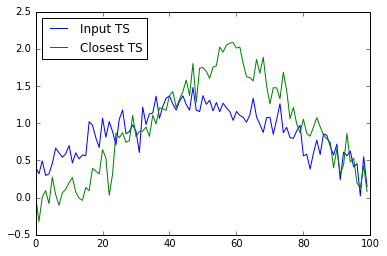

In [34]:
# visualize the results
plt.plot(query, label='Input TS')
plt.plot(tsdict[list(results.keys())[0]], label='Closest TS')
plt.legend(loc='best')
plt.show()

### Approximate Similarity Search

Runs an iSAX tree-based similarity search, which returns a faster but only returns an approximate result.

In [35]:
# TODO: add function signature

In [36]:
# TODO: examples

## Termination

Remember to terminate any outstanding processes.

In [37]:
server.terminate()
webserver.terminate()
web_interface = None